# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [2]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

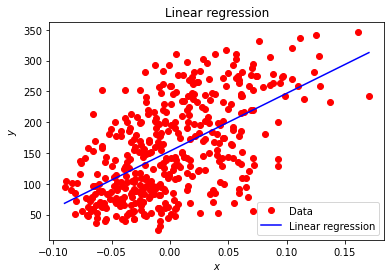

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [4]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [7]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

To show that $MSE(\hat{\theta}) = Bias^2(\hat{\theta}) + Var(\hat{\theta})$, I will first show that the definition of the MSE for estimators can be decomposed into its full form: (the numbers next to the equations indicate equation number for reference)
    
$$MSE = E[(\hat{\theta}-\theta)^2] \hspace{1cm} (1)$$
$$(\hat{\theta}-\theta)^2 = \hat{\theta}^2 + \theta^2 - 2\hat{\theta}\theta \hspace{1cm} (2)$$
    
Since the expected value of $\theta$ is equal to $\theta$, and the expected value of $\hat{\\theta}$ is equal to $E[\hat{\theta}]$, we find the following:

$$E[\hat{\theta}^2 + \theta^2 - 2\hat{\theta}\theta] = E[\hat{\theta}^2] + \theta^2 - 2E[\hat{\theta}]\theta \hspace{1cm} (3)$$ 

Next, I will show the same type of decomposition for the bias equation, $Bias(\hat{\theta}, \theta) = E[\hat{\theta}] - \theta$, but squared:

$$Bias^2(\hat{\theta}, \theta) = (E[\hat{\theta}] - \theta)^2 \hspace{1cm}  (4)$$
$$(E[\hat{\theta}] - \theta)^2 = E^2[\hat{\theta}] + \theta^2 - 2E[\hat{\theta}]\theta \hspace{1cm} (5)$$
   
Then, adding the variance, $Var(\hat{\theta}) = E[\hat{\theta}^2] - E^2[\hat{\theta}]$, to equation $5$, we get the following:
   
$$Bias^2(\hat{\theta}, \theta) + Var(\hat{\theta}) = E^2[\hat{\theta}] + \theta^2 - 2E[\hat{\theta}]\theta + E[\hat{\theta}^2] - E^2[\hat{\theta}] \hspace{1cm} (6)$$
   
$E^2[\hat{\theta}]$ and $-E^2[\hat{\theta}]$ cancel eachother out, so we are left with the following:
   
$$Bias^2(\hat{\theta}, \theta) + Var(\hat{\theta}) = E[\hat{\theta}^2] + \theta^2 - 2E[\hat{\theta}]\theta \hspace{1cm} (7)$$
   
Which is equal to equation $3$.
    
Thus, since the outcome of equation $3$ and equation $7$ are the same, we can conclude that, indeed:
   
$$MSE(\hat{\theta}) = Bias^2(\hat{\theta}) + Var(\hat{\theta})

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

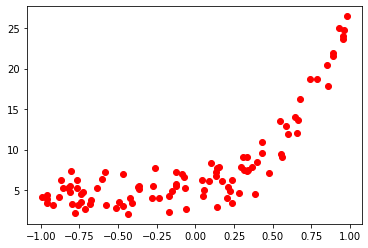

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Optimal degree of polynomials is 4
The mean squared error of the training data is 2.420854189233682
The mean squared error of the test data is 2.1663280357534735


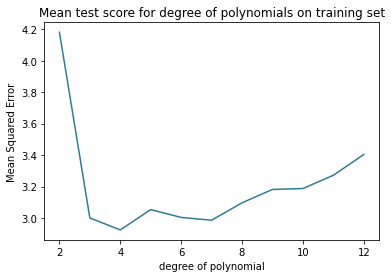

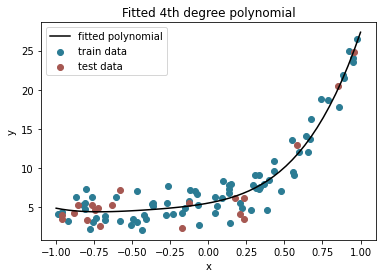

In [16]:
# import libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import metrics

# generate data set which has been done in the previous block of code
np.random.seed(0)
X, y = generate_dataset(n=100, degree=4, noise=1.5)

# divide the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=4)


# polynomial regression inspired by: https://stats.stackexchange.com/questions/453781/how-do-you-determine-what-degree-of-polynomial-to-fit-to-data
# make pipeline in which the polynomial
pipe = make_pipeline(PolynomialFeatures(), LinearRegression())

# define the parameters needed for the gridsearch operation
degrees = np.arange(2,13)
parameters = {'polynomialfeatures__degree': degrees}
n_cross_val = 5     # use 80% of dataset for training every time

grid = GridSearchCV(estimator= pipe, param_grid= parameters, cv=n_cross_val,
                     scoring= 'neg_mean_squared_error')
grid.fit(X_train.reshape(-1,1),y_train)

# from the gridsearch operation, get the metric of the optimal degree of polynomial
deg = grid.best_params_['polynomialfeatures__degree']
print("Optimal degree of polynomials is "+ str(deg))
# get the metric scores for all polynomial degrees tested, the metric was 
# neg_mean_squared_error (convention sklearn), get rid of the negative sign
mse_pol_deg = -1* grid.cv_results_['mean_test_score']

# plot the mean squared error against the degrees of polynomial
plt.figure()
plt.plot(degrees,mse_pol_deg, color= "#2c7c94")
plt.xlabel("degree of polynomial")
plt.ylabel("Mean Squared Error")
plt.title("Mean test score for degree of polynomials on training set")

# predict the y value via the fitted polynomial
y_pred_train = grid.predict(X_train.reshape(-1,1))
y_pred_test = grid.predict(X_test.reshape(-1,1))

#Create a range for plotting the fitted polynomial
space = np.linspace(-1, 1)
space = space.reshape(-1,1)

# plot the test and train data together with the fitted polynomial
plt.figure()
plt.plot(space, grid.predict(space), "k", label= "fitted polynomial")
plt.scatter(X_train,y_train, color= "#2c7c94", label= "train data")
plt.scatter(X_test,y_test, color= "#a65852" , label= "test data")
plt.title("Fitted "+str(deg)+"th degree polynomial")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# obtain the mean squared error values of the train and test set
mse_train = metrics.mean_squared_error(y_pred_train, y_train)
print("The mean squared error of the training data is "+str(mse_train))
mse_test = metrics.mean_squared_error(y_pred_test, y_test)
print("The mean squared error of the test data is "+str(mse_test))


Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

ANSWER: Models with a high variance are too much based on the training set, and therefore the model performs badly on the test set (high mean squared error). This occurs when the degree of polynomials is too high, then the model overfits the data. 

On the other hand, a model with high bias is not complex enough and therefore unable to capture the relationship between the x and y variable. This happens when the polynomial degree is too low for the data. As a result, the model will perform badly both on the training as wel as on the test set. 

Optimal degree of polynomials is 3
The mean squared error of the training data is 4059.031534644274
The mean squared error of the test data is 3211.71572942742


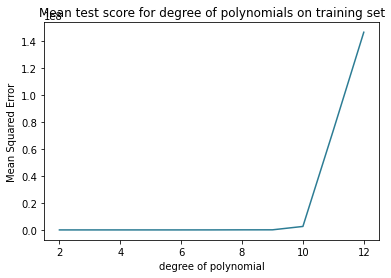

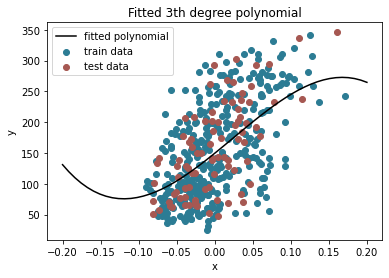

In [24]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import metrics

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# divide the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=4)

# polynomial regression inspired by: https://stats.stackexchange.com/questions/453781/how-do-you-determine-what-degree-of-polynomial-to-fit-to-data
# make pipeline in which the polynomial
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())

# define the parameters needed for the gridsearch operation
degrees = np.arange(2,13)
parameters = {'polynomialfeatures__degree': degrees}
n_cross_val = 5

grid = GridSearchCV(estimator= pipe, param_grid= parameters, cv=n_cross_val,
                     scoring= 'neg_mean_squared_error')
grid.fit(X_train.reshape(-1,1),y_train)

# from the gridsearch operation, get the metric of the optimal degree of polynomial
deg = grid.best_params_['polynomialfeatures__degree']
print("Optimal degree of polynomials is "+ str(deg))
# get the metric scores for all polynomial degrees tested, the metric was 
# neg_mean_squared_error (convention sklearn), get rid of the negative sign
mse_pol_deg = -1* grid.cv_results_['mean_test_score']


# plot the mean squared error against the degrees of polynomial
plt.figure()
plt.plot(degrees,mse_pol_deg, color= "#2c7c94")
plt.xlabel("degree of polynomial")
plt.ylabel("Mean Squared Error")
plt.title("Mean test score for degree of polynomials on training set")

# predict the y value via the fitted polynomial
y_pred_train = grid.predict(X_train.reshape(-1,1))
y_pred_test = grid.predict(X_test.reshape(-1,1))

#Create a range for plotting the fitted polynomial
space = 0.1*np.linspace(-2, 2)
space = space.reshape(-1,1)


# plot the test and train data together with the fitted polynomial
plt.figure()
plt.plot(space, grid.predict(space), "k", label= "fitted polynomial")
plt.scatter(X_train,y_train, color= "#2c7c94", label= "train data")
plt.scatter(X_test,y_test, color= "#a65852" , label= "test data")
plt.title("Fitted "+str(deg)+"th degree polynomial")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# obtain the mean squared error values of the train and test set
mse_train = metrics.mean_squared_error(y_pred_train, y_train)
print("The mean squared error of the training data is "+str(mse_train))
mse_test = metrics.mean_squared_error(y_pred_test, y_test)
print("The mean squared error of the test data is "+str(mse_test))


### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

In [8]:
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

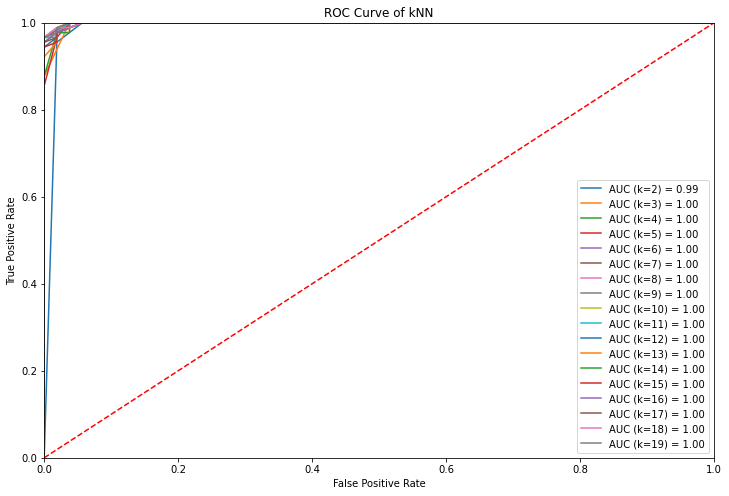

In [9]:
import sklearn

params = [i for i in range(2, 20)]

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic curve')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')

for k in params:
    
    model = Pipeline([
                 ("scaler", StandardScaler()),
                 ("knn", neighbors.KNeighborsClassifier(n_neighbors=k))
                ])
    
    model.fit(X_train, y_train)
    
    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    roc_auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label = 'AUC (k=%i) = %0.2f' % (k, roc_auc))

plt.legend(loc = 'lower right')
plt.show()

The more in the top left the ROC curve is, the better the method is at classifying. The above curves represent how well the different kNN-classifiers perform on the test data. All numbers of neighbors $k$ are better at classification than $k=2$, since their AUC is higher and their curves are more in the top left corner of the plot.

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


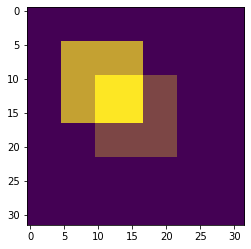

In [19]:
# generate some test objects
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

The Dice similarity coefficient could already be seen in the formula above, but can be rewritten as, see also https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4533825/

$ \text{Dice} =  {2*\text{TP} \over 2*\text{TP} + \text{FP} + \text{FN} } $ 

This is the formula for boolean or binary predictions, using measures of the confusion matrix also shown in the table below. The ground truth is tested against the predictions, and correct predictions are either True Positives (TP) or True Negatives (TN).


|                    | Ground truth = 1 | Ground truth = 0 |
|--------------------|------------------|------------------|
| **Prediction = 1** | TP               | FP               |
| **Prediction = 0** | FN               | TN               |

Using these expressions, precision can be defined as:
$ \text{Precision} = {\text{TP} \over \text{TP} + \text{FP}} $

This metric indicates the portion of correctly predicted positive samples of all samples predicted as positive.

Recall can be defined as:
$ \text{Recall} = {\text{TP} \over \text{TP} + \text{FN}} $

This metric indicates the portion of positive samples being recognized as positive by the model.

Since the $F_1$ score is the harmonic mean of these two metrics, the score can be defined as:

$F_1 = {2 \over \text{Precision}^{-1} + \text{Recall}^{-1}} = {2{ \text{Precision} \cdot \text{Recall} \over \text{Precision} + \text{Recall} }} = 2{{{TP^2} \over {(TP + FP)(TP + FN)}} \over {{TP(TP + FP) + TP(TP + FN)} \over {(TP + FP)(TP + FN)}}} = 2{TP^2 \over {TP(TP + FP) + TP(TP + FN)}} = {2*{TP} \over 2*{TP} + {FP} + {FN} } = \text{Dice} $ 

As seen above, the $F_1$ score and Dice similarity coefficient are equivalent.



